In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import csv
import os
import sys
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

56 workers and 1 cores, 1020.9 in 57.59 seconds
1 workers and 56 cores, 808.7 in 56.68 seconds
24 workers and 24 cores, 802.2 in 49.0 seconds
24 workers and 56 cores, 802.2 in 47.51 seconds
56 workers and 24 cores, 805.1 in 59.8 seconds


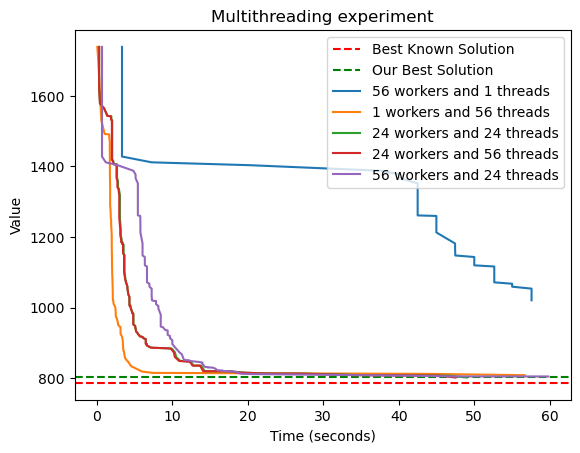

In [3]:
## Multithreading experiment
# Outdated

from integer_model import *

fnames = ["R109-56-56.json", "R109-56-1.json", "R109-24-24.json", "R109-24.json", "R109-56.json"]

instances = []
for fname in fnames:
    instance = Integer_model()
    instance.read_json(fname)
    instances.append(instance)

instance = instances[0]
instances.remove(instance)
for instancem in instances:
    instance.instance['solutions'].append(instancem.instance['solutions'][0])


# plt.yscale('log')
best = instance.instance['best_known_solution']['Distance']
if best != '':
    best_known_solution = float(best)
    plt.axhline(y=best_known_solution, color='r', linestyle='--', label='Best Known Solution')
if instance.instance['our_best_solution']:
    our_best_solution = 802.2
    plt.axhline(y=our_best_solution, color='g', linestyle='--', label='Our Best Solution')

for solution in instance.instance['solutions']:
    # print(solution['n_workers'])
    # print(solution['n_cores'])
    # print(solution['total_distance'])
    print(f'{solution["n_workers"]} workers and {solution["n_cores"]} cores, {solution["total_distance"]} in {solution["search_progress"][-1][1]} seconds')
    numbers = [entry[0] for entry in solution['search_progress']]
    times = [entry[1] for entry in solution['search_progress']]
    plt.plot(times, numbers, label=f'{solution["n_workers"]} workers and {solution["n_cores"]} threads')



# Plot the data

plt.ylabel('Value')
plt.xlabel('Time (seconds)')
plt.title('Multithreading experiment')
plt.legend(loc='upper right')

# plt.ylim(min(times), max(times + [best_known_solution]))

# Display the plot
plt.show()

In [20]:
# Load all data into a DataFrame

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the files in the folder

data_folder = '..\\..\\data\\VRPTW\\'  # Specify the folder name where the data files are located
# cvrptw_prob = VRPTW()

for folder_name in os.listdir(data_folder):
    if not os.path.isdir(os.path.join(data_folder, folder_name)):
        continue
    folder_path = os.path.join(data_folder, folder_name)
    for filename in os.listdir(folder_path):
        if filename.endswith('.json'):
            # Read the JSON file

            id = filename.split('.')[0]+ '.' + folder_name.split('_')[1]
            instance_name = filename.split('.')[0]
            file_path = os.path.join(folder_path, filename)
            with open(file_path) as f:
                data = json.load(f)

            # Extract the required data from the JSON
            benchmark = data['instance_kind']
            N = data['data']['nb_customers']
            best_known_solution = data['reference_solution']
            # old solutions
            solutions = [{'solver_name': f'{sol["solver"] if "solver" in sol.keys() else "Docplex, integer model"}', 
                    'n_workers': sol['n_workers'] if 'n_workers' in sol.keys() else 0,
                    'total_distance': sol['total_distance'],
                    'number_of_vehicles': sol['n_vehicles'] if 'n_vehicles' in sol.keys() else sol['vehicles'],
                    'timeout': sol['time'],
                    'time': sol['search_progress'][-1][1] if 'search_progress' in sol.keys() else sol['time']}
                    for sol in data['run_history'][:3]]
            # new solutions
            solutions.extend([{'solver_name': sol["solver_name"], 
                    'n_workers': sol['solver_config']['NoWorkers'],
                    'total_distance': sol['solution_info']['total_distance'],
                    'number_of_vehicles': sol['solution_info']['n_vehicles'],
                    'timeout': sol['solve_time'][0],
                    'time': sol['solution_progress'][-1][1]}
                    for sol in data['run_history'][3:]])

            # print(solutions)

            horizon = instance_name[2] if instance_name[:2] == 'RC' else instance_name[1]

            # Create a DataFrame with the extracted data
            df = pd.DataFrame({
                'benchmark': [benchmark],
                'name': [instance_name],
                'N': [N],
                'horizon': 'short' if horizon == '1' else 'long',
                'sampling': 'RC' if instance_name[:2] == 'RC' else instance_name[0],
                'best_known_solution': [best_known_solution],
                'solutions': [solutions]
            })

            # df = df.assign(solutions=[solutions])

            # Append the DataFrame to the list
            dfs.append(df)
            # break

# Concatenate the list of DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Display the resulting DataFrame
print(result_df)


    benchmark   name    N horizon sampling             best_known_solution  \
0      CVRPTW   C101  100   short        C  {'optimum': 827.3, 'NV': 10.0}   
1      CVRPTW   C102  100   short        C  {'optimum': 827.3, 'NV': 10.0}   
2      CVRPTW   C103  100   short        C  {'optimum': 826.3, 'NV': 10.0}   
3      CVRPTW   C104  100   short        C  {'optimum': 822.9, 'NV': 10.0}   
4      CVRPTW   C105  100   short        C  {'optimum': 827.3, 'NV': 10.0}   
..        ...    ...  ...     ...      ...                             ...   
162    CVRPTW  RC204   50    long       RC   {'optimum': 444.2, 'NV': 3.0}   
163    CVRPTW  RC205   50    long       RC   {'optimum': 630.2, 'NV': 5.0}   
164    CVRPTW  RC206   50    long       RC   {'optimum': 610.0, 'NV': 5.0}   
165    CVRPTW  RC207   50    long       RC   {'optimum': 558.6, 'NV': 4.0}   
166    CVRPTW  RC208   50    long       RC   {'optimum': 476.7, 'NV': 3.0}   

                                             solutions  
0    [

In [21]:
#save df

# result_df.to_csv('..\\..\\data\\VRPTW\\result_df.csv', index=False)
result_df.to_json('..\\..\\data\\VRPTW\\result_df.json', orient='records', force_ascii=False, default_handler=str)


In [3]:
#load df

# result_df = pd.read_csv('..\\..\\data\\VRPTW\\result_df.csv') - converts arrays and dicts to strings
result_df = pd.read_json('..\\..\\data\\VRPTW\\result_df.json', orient='records')


In [22]:
# Sorting

result_df = result_df.sort_values(by=[ 'N', 'name',])

In [154]:
# DataFrame with data about each solve
solvers_data = []

for index, row in result_df.iterrows():
    best = row['best_known_solution']['optimum']
    solutions = row['solutions']
    solutions.sort(key=lambda x: (x.get('total_distance', float('inf')), x.get('number_of_vehicles', float('inf')), x.get('time', float('inf'))))
    seen_solvers = set()  # Keep track of solvers already added
    for solution in solutions:
        solver_name = solution.get('solver_name', 'Unknown')
        # Only add the best solution for each solver
        if solver_name not in seen_solvers:
            relative_distance = solution.get('total_distance', 0) / best
            time = solution.get('time', 0)
            timeout = solution.get('timeout', False)
            number_of_vehicles = solution.get('number_of_vehicles', 0)
            solvers_data.append({'ID': row['name']+'.'+str(row['N']), 'Name': row['name'], 'N': row['N'], 'horizon': row['horizon'], 'sampling': row['sampling'],
                                 'solver_name': solver_name, 'relative_distance': relative_distance, 'total_distance': solution.get('total_distance', 0),
                                 'time': time, 'timeout': timeout, 'number_of_vehicles': number_of_vehicles})
            seen_solvers.add(solver_name)

solvers = pd.DataFrame(solvers_data)

In [152]:
unique_solver_names = solvers['solver_name'].unique()
custom_palette = sns.color_palette('tab10', n_colors=len(unique_solver_names))

In [161]:
# Great function for better label tics
# y label positions change based on resolution of the plot, the default values are for figsize=(14,7)

def awesome_tics(ax, y_label_abs=0.033, y_label_rel=400):
    ax.set_xticks([])
    ax.xaxis.labelpad = 65
    
    axis = []
    keys = ['N', 'horizon', 'sampling']
    horizons = solvers.get(keys)
    ticss = []
    for key in horizons.keys():
        list_key = horizons.get(key).tolist()
    
        last = list_key[0]
        ax_tics = [last]
        for i in range(1, len(list_key)):
            if list_key[i] != last:
                ax_tics.append(list_key[i])
                last = list_key[i]
        ticss.append(ax_tics)
    
    # order tics by length reverse
    tics_order = np.argsort([len(tics) for tics in ticss],)[::-1]
    for i in tics_order:
        ax_tics = ticss[i]
        key = keys[i]
        if len(ax_tics) == len(solvers['ID'].unique()):
            continue
    
        ax_tics.append('')
    
        # tics = np.linspace(start=0, stop=len(result_df), num=len(ax_tics))
    
        axis.append(ax.twiny())
        newax = axis[-1]
        # newax.set_frame_on(True)
        # newax.patch.set_visible(False)
        newax.xaxis.set_ticks_position('bottom')
        newax.xaxis.set_label_position('bottom')
        xoffset = 20 * (len(axis) - 1)
        newax.spines['bottom'].set_position(('outward', xoffset))
        newax.annotate(key + ':', xy=(-0.01, -(xoffset/y_label_rel) - y_label_abs), xytext=(5, 0), ha='right', xycoords='axes fraction', textcoords='offset points')
    
        atics = np.linspace(start=0, stop=len(result_df), num=len(ax_tics))
        newax.set_xticks(atics, labels=ax_tics, )
        ax_tics=ax_tics[:-1]
        tics = np.linspace(start=0, stop=len(result_df), num=(len(ax_tics)*2)+1)
        tics = tics[1::2]
        newax.set_xticks(tics, labels=ax_tics, minor=True)
        newax.xaxis.set_major_formatter(ticker.NullFormatter())
        newax.tick_params(axis='x', which='minor', tick1On=False, tick2On=False)
        # for label in newax.get_xticklabels():
        #     label.set_horizontalalignment('center')
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.05)

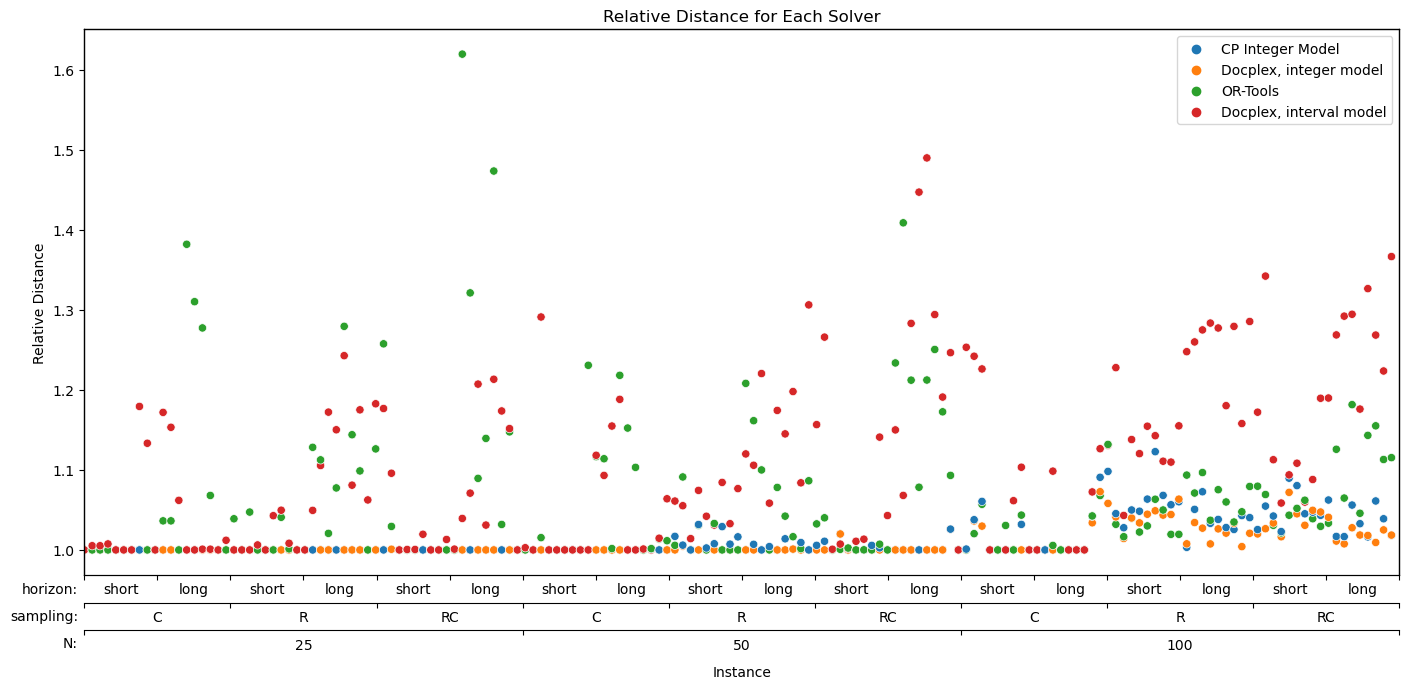

In [162]:
# Plot total distance from solutions

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlim([0, len(result_df)])

sns.scatterplot(data=solvers, x='ID', y='relative_distance', hue='solver_name', palette=custom_palette)
plt.xlabel('Instance')
plt.ylabel('Relative Distance')
plt.title('Relative Distance for Each Solver')
ax.legend()
# print x tics
# tics = ax.get_xticklabels()
# names = result_df['name']+'.'+result_df['N'].astype(str).values
# for tic, name in zip(tics, names):
#     print(tic, name)

awesome_tics(ax)

plt.savefig('plots/relative_distance.png')
plt.show()


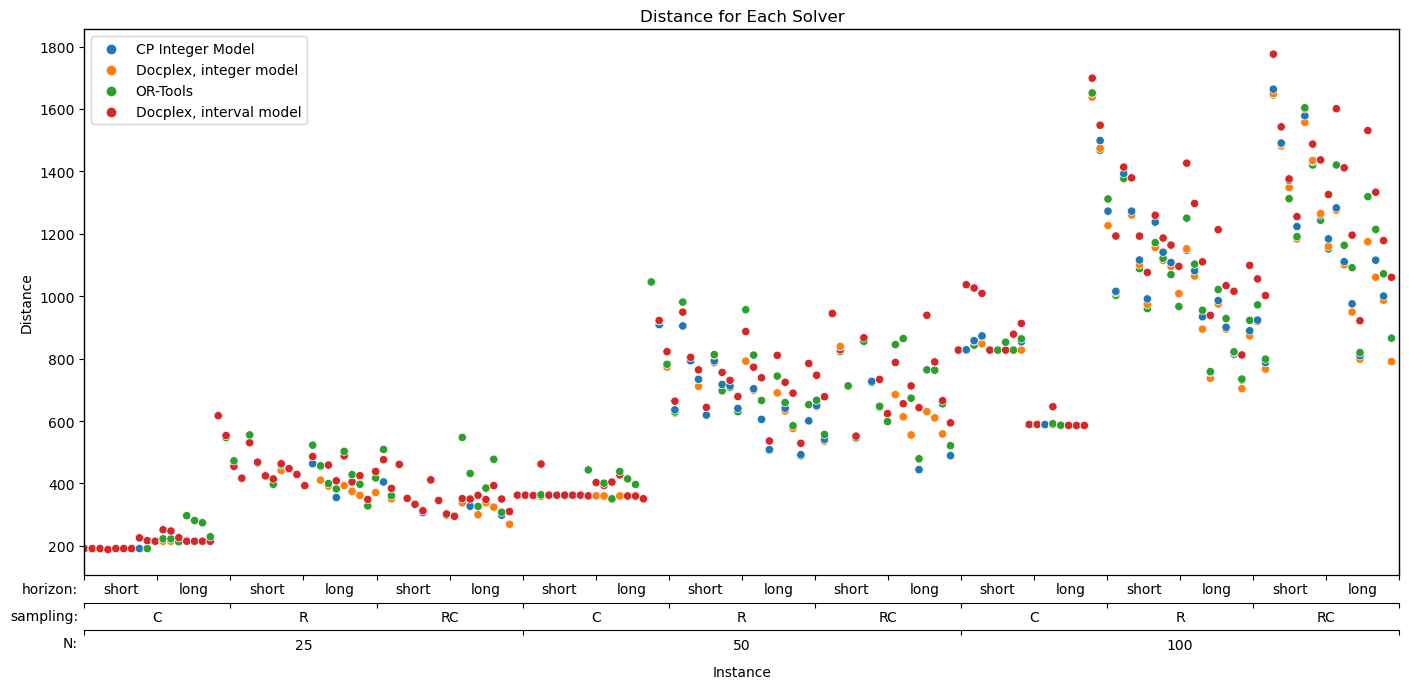

In [163]:
# Plot total distance from solutions

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlim([0, len(result_df)])

sns.scatterplot(data=solvers, x='ID', y='total_distance', hue='solver_name', palette=custom_palette)
plt.xlabel('Instance')
plt.ylabel('Distance')
plt.title('Distance for Each Solver')
ax.legend()
# print x tics
# tics = ax.get_xticklabels()
# names = result_df['name']+'.'+result_df['N'].astype(str).values
# for tic, name in zip(tics, names):
#     print(tic, name)

awesome_tics(ax)

plt.savefig('plots/distance.png')
plt.show()


In [90]:
# Group the results by horizon, sampling, and N
grouped_results = solvers.groupby(['horizon', 'sampling', 'N', 'solver_name'])

# Calculate statistics for each group
grouped_stats = grouped_results.agg({'relative_distance': 'mean', 'time': 'mean', 'number_of_vehicles': 'mean', 'Name': 'count'}).reset_index()

# Add an ID column
grouped_stats['ID'] = grouped_stats.apply(lambda row: f"{row['horizon']}-{row['sampling']}-{row['N']}", axis=1)

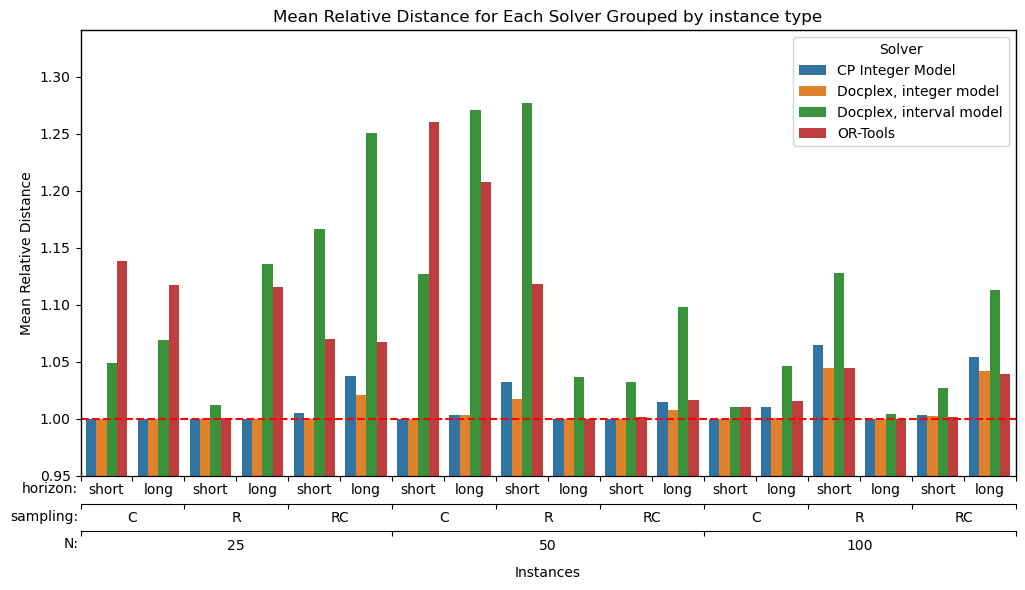

In [164]:
# Find the lowest value
lowest_value = grouped_stats['relative_distance'].min()

# Plot the data
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=grouped_stats, x='ID', y='relative_distance', hue='solver_name', palette=custom_palette)
plt.xlabel('Instances')
plt.ylabel('Mean Relative Distance')
plt.title('Mean Relative Distance for Each Solver Grouped by instance type')
plt.xticks(rotation=90)
plt.legend(title='Solver') 
plt.ylim(lowest_value - 0.05) 
plt.axhline(y=1, color='r', linestyle='--')

awesome_tics(ax, y_label_abs=0.039, y_label_rel=325)

plt.savefig('plots/relative_distance_grouped.png')
plt.show()


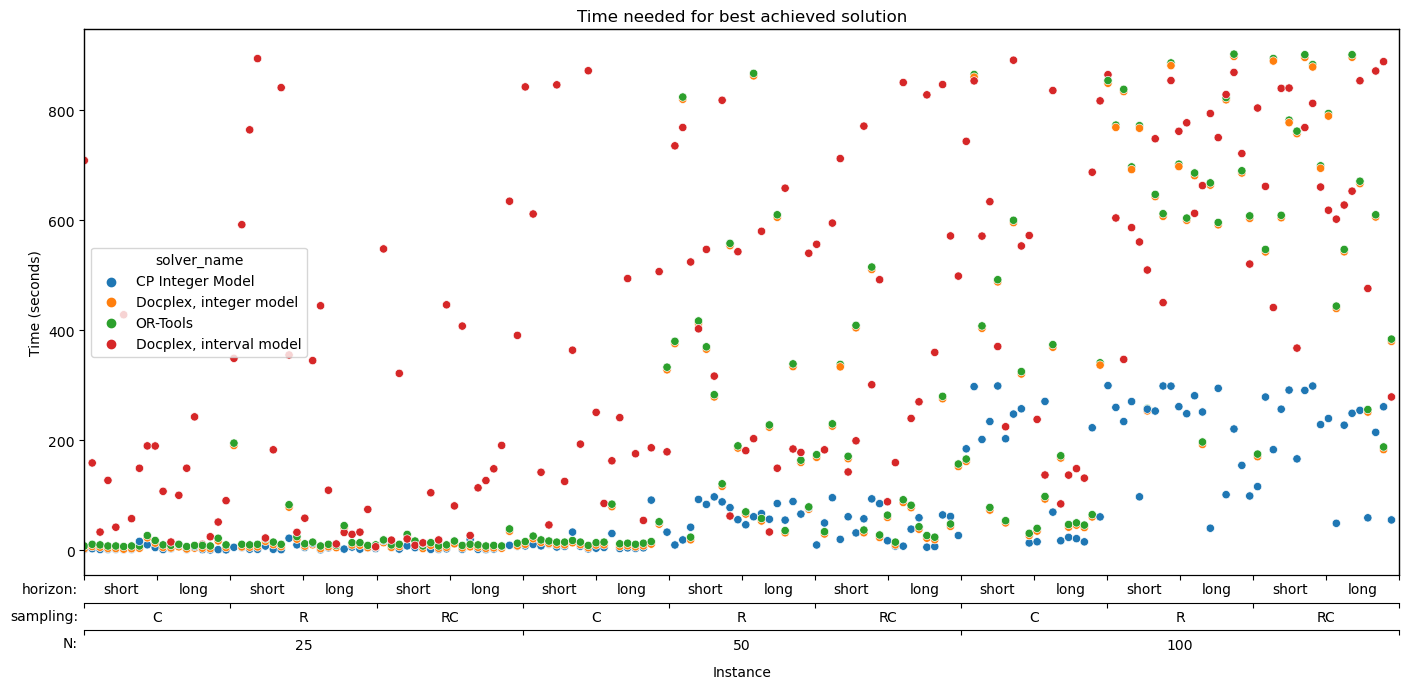

In [165]:
# Plot total time from solutions

fig, ax = plt.subplots(figsize=(14,7))
ax.set_xlim([0, len(result_df)])
sns.scatterplot(data=solvers, x='ID', y='time', hue='solver_name', palette=custom_palette)

# plt.yscale('log')

plt.ylabel('Time (seconds)')
plt.xlabel('Instance')
plt.title('Time needed for best achieved solution')
# ax.legend()

awesome_tics(ax)

plt.savefig('plots/time.png')
plt.show()


- Analysis of Best Known Results

In [4]:
import math
import pandas as pd

# Load the CSV file
res_path = "..\\..\\data\\VRPTW\\best.csv"
df = pd.read_csv(res_path, sep=';', header=None, encoding='ISO-8859-1')

# Extract sources and problem labels
sources = df.iloc[0, ::5].reset_index(drop=True)
problem_labels = df.iloc[1, ::5].reset_index(drop=True)

# Extract results
problems = df.iloc[2:, ::5].reset_index(drop=True)
nv = df.iloc[2:, 1::5].reset_index(drop=True)
dist = df.iloc[2:, 2::5].reset_index(drop=True)

print(len(sources))
print(len(problem_labels))
print(problems.shape)
print(nv.shape)
print(dist.shape)


# Initialize an empty DataFrame to store the final results
data = []

# Iterate over each source, problem, NV, and Distance to extract the data
for i in range(len(sources)):
    source = sources[i]
    for problem, nv_value, dist_value in zip(problems.iloc[:, i], nv.iloc[:, i], dist.iloc[:, i]):
        # check if problem is not empty string
        if not isinstance(problem, str) and math.isnan(problem):
            continue
        # remove spaces
        problem = problem.strip()
        if '.' not in problem:
            problem += '.100'
        if isinstance(dist_value, str) and ',' in dist_value:
            dist_value = dist_value.replace(',', '.')
        if isinstance(nv_value, str) and not isinstance(nv_value, float):
            nv_value = int(nv_value)
        # problem to capital letters
        problem = problem.upper()
        data.append([source, problem, nv_value, float(dist_value)])

# Create the DataFrame
final_df = pd.DataFrame(data, columns=['Source', 'Instance', 'NV', 'Distance'])

print(final_df)

28
28
(168, 28)
(168, 28)
(168, 28)
        Source   Instance    NV  Distance
0        GIT 1   C101.100  10.0    828.90
1        GIT 1   C102.100  10.0    828.90
2        GIT 1   C103.100  10.0    828.10
3        GIT 1   C104.100  10.0    825.60
4        GIT 1   C105.100  10.0    828.90
...        ...        ...   ...       ...
2833  Random 2  RC204.100   NaN   1501.48
2834  Random 2  RC205.100   NaN   2239.37
2835  Random 2  RC206.100   NaN   1911.61
2836  Random 2  RC207.100   NaN   2055.97
2837  Random 2  RC208.100   NaN   1483.66

[2838 rows x 4 columns]


In [5]:
# compute relative distance to best known solution

# Group the data by instance and find the minimum distance for each instance
min_distances = final_df.groupby('Instance')['Distance'].min()

# Compute relative distance for each distance value within each instance group
final_df['Relative Distance'] = final_df.apply(lambda row: row['Distance'] / min_distances[row['Instance']], axis=1)


In [6]:
# Group the results by instance
grouped_results = final_df.groupby('Instance')

# Define a function to print the results for each instance
def print_results(group):
    print(f"Instance: {group.name}")
    # Sort the group by distance
    sorted_group = group.sort_values(by='Distance')
    for index, row in sorted_group.iterrows():
        print(f"    Source: {row['Source']}, Distance: {row['Distance']}, NV: {row['NV']}")
    print()

# Apply the function to each group
grouped_results.apply(print_results)


Instance: C101.100
    Source: http://hjemmesider.diku.dk/~spooren/solomon/r1r2solu.htm, Distance: 827.3, NV: 10.0
    Source: http://web.cba.neu.edu/~msolomon/c1c2solu.htm, Distance: 827.3, NV: 10.0
    Source: Optimal value 2, Distance: 827.3, NV: nan
    Source: http://vrp.atd-lab.inf.puc-rio.br/index.php/en/, Distance: 827.3, NV: nan
    Source: Optimal value, Distance: 827.3, NV: nan
    Source: GIT 1, Distance: 828.9, NV: 10.0
    Source: GIT 2, Distance: 828.9, NV: 10.0
    Source: GIT 3, Distance: 828.9, NV: 10.0
    Source: ACO-TS, Distance: 828.93, NV: 10.0
    Source: https://sun.aei.polsl.pl//~zjc/best-solutions-solomon.html, Distance: 828.93664, NV: 10.0
    Source: Random, Distance: 828.937, NV: nan
    Source: SPOT, Distance: 828.937, NV: nan
    Source: ParamILS, Distance: 828.937, NV: nan
    Source: HSFLA, Distance: 828.94, NV: 10.0
    Source: S-PSO, Distance: 828.94, NV: 10.0
    Source: PITSH, Distance: 828.94, NV: 10.0
    Source: CPLA, Distance: 828.94, NV: 10.0


""


In [7]:
for source1 in sources:
    df1 = final_df[final_df['Source'] == source1]
    for source2 in sources:
        if source1 == source2:
            continue
        df2 = final_df[final_df['Source'] == source2]
        if df1['Distance'].values.tolist() == df2['Distance'].values.tolist():
            print(f"Source {source1} and {source2} have the same instances")

Source Optimal value and Optimal value 2 have the same instances
Source Optimal value 2 and Optimal value have the same instances


In [8]:
# which source has the lowest relative distance average

# Group the data by source and compute the average relative distance for each source
source_relative_distance = final_df.groupby('Source')['Relative Distance'].sum().sort_values()

# Print the results
print(source_relative_distance)

Source
http://vrp.atd-lab.inf.puc-rio.br/index.php/en/                   56.224811
GIT 2                                                             56.650350
MFGA                                                              56.926866
GIT 3                                                             57.907458
CPLA                                                              58.471164
ACO-TS                                                            58.636006
GIT 1                                                             58.654940
https://www.sintef.no/projectweb/top/vrptw/100-customers/         58.855656
https://sun.aei.polsl.pl//~zjc/best-solutions-solomon.html        58.856156
HSFLA                                                             58.861909
PITSH                                                             58.864696
S-PSO                                                             60.590006
https://www.preprints.org/manuscript/202206.0074/v1               82.899055
https

In [9]:
# how many times has each source the best result by counting the number of times each source has the relative distance equal to 1

# Group the data by source and count the number of times each source has the relative distance equal to 1
best_results = final_df[final_df['Relative Distance'] == 1].groupby('Source')['Relative Distance'].count().sort_values()

# Print the results
print(best_results)

Source
ACO-TS                                                        1
MFGA                                                          8
http://vrp.atd-lab.inf.puc-rio.br/index.php/en/              48
https://www.preprints.org/manuscript/202206.0074/v1          61
http://web.cba.neu.edu/~msolomon/c1c2solu.htm               138
Optimal value                                               140
Optimal value 2                                             140
http://hjemmesider.diku.dk/~spooren/solomon/r1r2solu.htm    154
Name: Relative Distance, dtype: int64


In [10]:
# print all results where source is https://www.diva-portal.org/smash/get/diva2:419232/FULLTEXT01.pdf - old  

temp = final_df[final_df['Source'] == 'https://www.diva-portal.org/smash/get/diva2:419232/FULLTEXT01.pdf - old']

In [24]:
folder = "..\\..\\data\\VRPTW\\"

for subfolder in os.listdir(folder):
    if not os.path.isdir(os.path.join(folder, subfolder)):
        continue
    for file in os.listdir(os.path.join(folder, subfolder)):
        if file.endswith('.json'):
            instance_name = file.split('.')[0] + '.' + subfolder.split('_')[1]
            results = final_df[final_df['Instance'] == instance_name]
            # sort by distance and nv
            results = results.sort_values(by=['Distance', 'NV'])
            best = results.iloc[0]
            print(instance_name, best['Distance'], best['NV'])
            
            # open file 
            with open(os.path.join(folder, subfolder, file), 'r') as f:
                data = json.load(f)
            
            data['reference_solution'] = {
                'optimum': best['Distance'],
                'NV': best['NV']
            }
            
            # save file
            with open(os.path.join(folder, subfolder, file), 'w') as f:
                json.dump(data, f, indent=4)

C101.100 827.3 10.0
C102.100 827.3 10.0
C103.100 826.3 10.0
C104.100 822.9 10.0
C105.100 827.3 10.0
C106.100 827.3 10.0
C107.100 827.3 10.0
C108.100 827.3 10.0
C109.100 827.3 10.0
C201.100 589.1 3.0
C202.100 589.1 3.0
C203.100 588.7 3.0
C204.100 588.1 3.0
C205.100 586.4 3.0
C206.100 586.0 3.0
C207.100 585.8 3.0
C208.100 585.8 3.0
R101.100 1584.0 19.0
R102.100 1374.2 16.0
R103.100 1158.9 13.0
R104.100 971.5 11.0
R105.100 1355.3 15.0
R106.100 1212.1 13.0
R107.100 1064.6 11.0
R108.100 932.1 10.0
R109.100 1101.99 12.0
R110.100 1068.0 12.0
R111.100 1048.7 12.0
R112.100 948.6 10.0
R201.100 1143.2 8.0
R202.100 1029.6 8.0
R203.100 870.8 6.0
R204.100 731.3 nan
R205.100 949.8 5.0
R206.100 875.9 5.0
R207.100 794.0 4.0
R208.100 701.0 nan
R209.100 854.8 9.0
R210.100 900.5 6.0
R211.100 746.7 nan
RC101.100 1595.9 15.0
RC102.100 1457.4 14.0
RC103.100 1258.0 11.0
RC104.100 1132.3 10.0
RC105.100 1510.1 15.0
RC106.100 1367.2 13.0
RC107.100 1207.8 12.0
RC108.100 1114.2 11.0
RC201.100 1261.8 9.0
RC202.100 

------------
GA heuristic analysis

In [3]:
import os
import time

from src.vrp.solvers.ga_model import *
from src.vrp.problem import *

decoders = [decode_chromosome_fast, decode_chromosome_rec_pruned_less2, decode_chromosome_rec_pruned_less, decode_chromosome_rec_pruned]

folder1 = "..\\..\\data\\VRPTW"

res = []

for folder in os.listdir(folder1):
    if not os.path.isdir(os.path.join(folder1, folder)):
        continue
    for file in os.listdir(os.path.join(folder1, folder)):
        if file.endswith('.json'):
            instance_name = file.split('.')[0] + '.' + folder.split('_')[1]
            print(f"Processing {instance_name}")
            path = os.path.join(folder1, folder, file)
            instance = load_instance(path)
            
            # convert to chromosome
            sol = instance._run_history[-1]['solution_info']
            dist = sol['total_distance']
            paths = sol['paths']
            
            # flatten paths and remove all 0
            chromosome = [customer for path in paths for customer in path if customer != 0]
            # print(f"Original length: {dist}\n{paths}")
            # print(f"Chromosome: {chromosome}")
            
            for decoder in decoders:
                start = time.time()
                routes, length = decoder(instance, chromosome)
                validate_path({'paths':routes}, instance)
                length /= 10
                tim = time.time() - start
                # times[file+'-'+decoder.__name__] = time.time() - start
                res.append({'instance': file.split('.')[0], 'N': folder.split('_')[1], 'decoder': decoder.__name__, 'time': tim, 'original_dist': dist, 'new_dist': length, 'failed': length != dist, 'routes': routes})


Processing C101.100
Processing C102.100
Processing C103.100
Processing C104.100
Processing C105.100
Processing C106.100
Processing C107.100
Processing C108.100
Processing C109.100
Processing C201.100
Processing C202.100
Processing C203.100
Processing C204.100
Processing C205.100
Processing C206.100
Processing C207.100
Processing C208.100
Processing R101.100
Processing R102.100
Processing R103.100
Processing R104.100
Processing R105.100
Processing R106.100
Processing R107.100
Processing R108.100
Processing R109.100
Processing R110.100
Processing R111.100
Processing R112.100
Processing R201.100
Processing R202.100
Processing R203.100
Processing R204.100
Processing R205.100
Processing R206.100
Processing R207.100
Processing R208.100
Processing R209.100
Processing R210.100
Processing R211.100
Processing RC101.100
Processing RC102.100
Processing RC103.100
Processing RC104.100
Processing RC105.100
Processing RC106.100
Processing RC107.100
Processing RC108.100
Processing RC201.100
Processing 

In [4]:
# res to df
import pandas as pd
df = pd.DataFrame(res)

In [10]:
# print results
print(df)

    instance    N                             decoder      time  \
0       C101  100              decode_chromosome_fast  0.001001   
1       C101  100  decode_chromosome_rec_pruned_less2  0.003000   
2       C101  100   decode_chromosome_rec_pruned_less  0.010002   
3       C101  100        decode_chromosome_rec_pruned  0.011003   
4       C102  100              decode_chromosome_fast  0.001000   
..       ...  ...                                 ...       ...   
663    RC207   50        decode_chromosome_rec_pruned  0.004001   
664    RC208   50              decode_chromosome_fast  0.000000   
665    RC208   50  decode_chromosome_rec_pruned_less2  0.001000   
666    RC208   50   decode_chromosome_rec_pruned_less  0.002001   
667    RC208   50        decode_chromosome_rec_pruned  0.003001   

     original_dist  new_dist  failed  \
0            827.3     784.5    True   
1            827.3     827.3   False   
2            827.3     827.3   False   
3            827.3     827.3   Fals

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

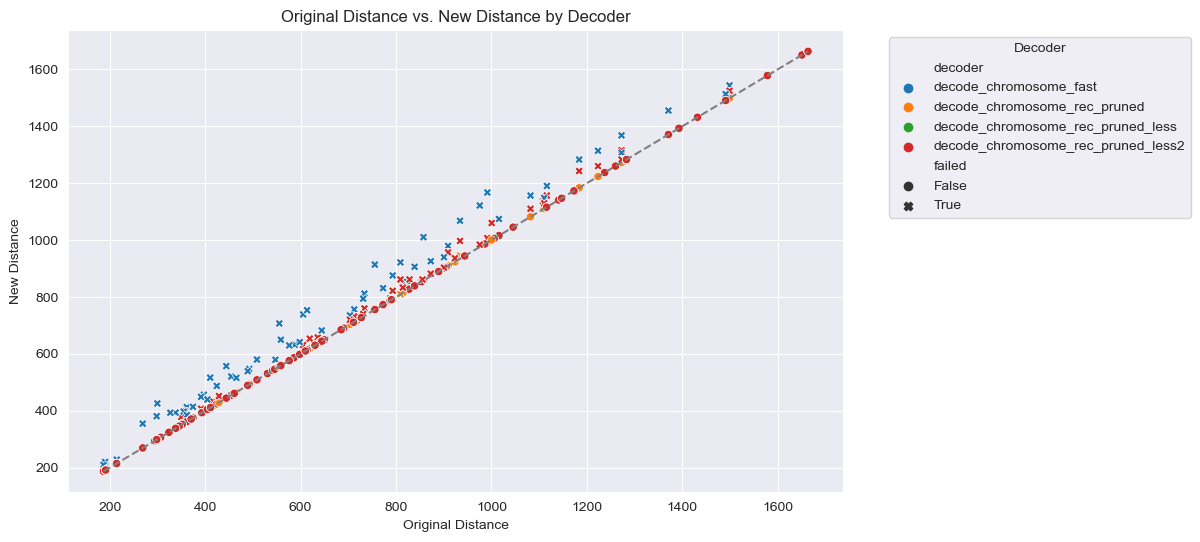

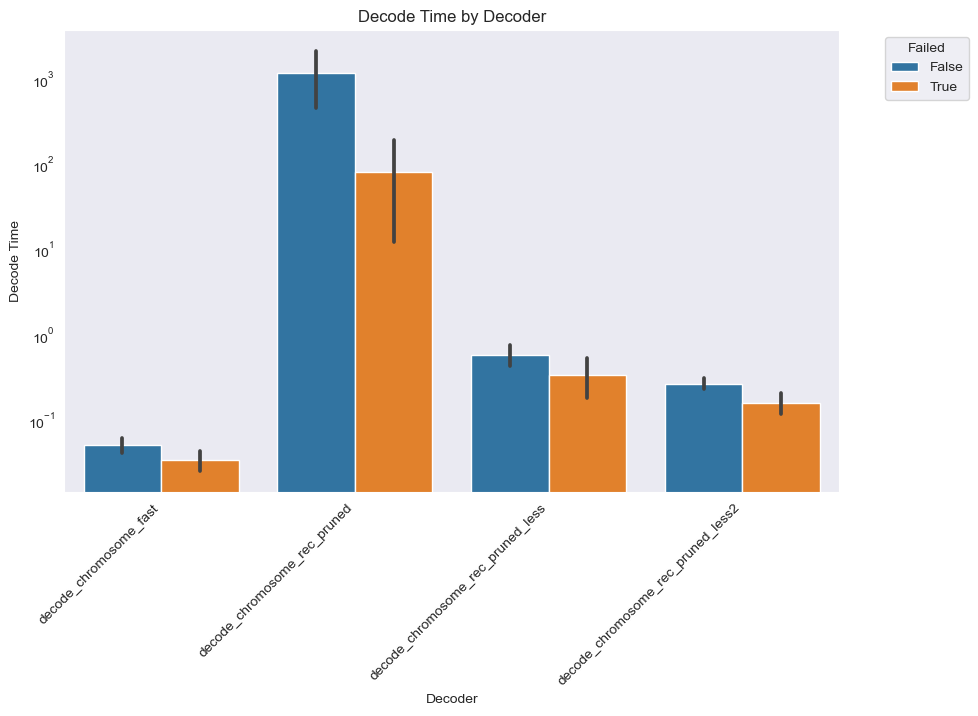

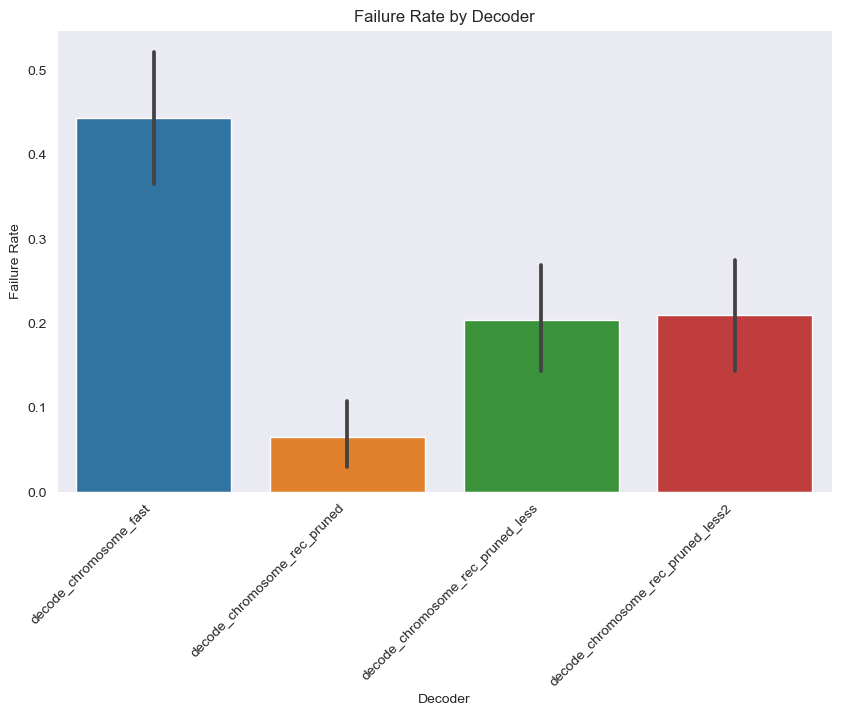

Number of fails for each decoder:
decode_chromosome_fast: 74
decode_chromosome_rec_pruned: 11
decode_chromosome_rec_pruned_less: 34
decode_chromosome_rec_pruned_less2: 35


In [6]:
df_sorted = df.sort_values(by=['instance', 'decoder'])

# Plotting original distance vs. new distance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sorted, x='original_dist', y='new_dist', hue='decoder', style='failed')
plt.plot([df_sorted['original_dist'].min(), df_sorted['original_dist'].max()], 
         [df_sorted['original_dist'].min(), df_sorted['original_dist'].max()], 
         color='gray', linestyle='--')
plt.title('Original Distance vs. New Distance by Decoder')
plt.xlabel('Original Distance')
plt.ylabel('New Distance')
plt.legend(title='Decoder', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# Plotting decode time by decoder
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x='decoder', y='time', hue='failed', estimator=sum)
plt.yscale('log')
plt.title('Decode Time by Decoder')
plt.xlabel('Decoder')
plt.ylabel('Decode Time')
plt.legend(title='Failed', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

# Plotting failure rate by decoder
plt.figure(figsize=(10, 6))
sns.barplot(data=df_sorted, x='decoder', y='failed', estimator=lambda x: sum(x) / len(x))
plt.title('Failure Rate by Decoder')
plt.xlabel('Decoder')
plt.ylabel('Failure Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()

fail_counts = df_sorted.groupby('decoder')['failed'].sum()

# Print the number of fails for each decoder
print("Number of fails for each decoder:")
for decoder, fails in fail_counts.items():
    print(f"{decoder}: {fails}")

In [26]:
filtered_df = df[df['new_dist'] < df['original_dist']]